In [1]:
import torch
import torch.nn as nn
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# %pip install torch_geometric

In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.nn as pyg_nn
import numpy as np
import pandas as pd


In [4]:
torch.cuda.device_count()

1

In [87]:
DATA_PATH = "ml-100k"

column_names=["user_id","item_id","rating","timestamp"]
data=pd.read_csv(DATA_PATH+"/u.data",delimiter="\t",names=column_names)
data

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [88]:
# In order to recommend a movie to other users , it should have a higher rating. So we will \
# searh for movies with higher ratings

len(data[data['rating']>3])

55375

In [89]:
data.groupby(['rating'])['rating'].count()

rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: rating, dtype: int64

In [90]:
from sklearn.model_selection import train_test_split

train,test=train_test_split(data.values,test_size=0.2,random_state=42)

In [91]:
train_data=pd.DataFrame(train,columns=column_names)
test_data=pd.DataFrame(test,columns=column_names)
train_data

,user_id,item_id,rating,timestamp
0,807,1411,1,893082619
1,474,659,5,887925187
2,463,268,4,877384940
3,139,286,4,879537844
4,621,751,4,883799651
...,...,...,...,...
79995,216,231,2,880245109
79996,343,276,5,876403078
79997,437,475,3,880140288
79998,284,322,3,885329671


In [92]:
import sklearn.preprocessing as pp

# ordering of the users and items might not be correct
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_data['user_id_idx'] = le_user.fit_transform(train_data['user_id'].values)
train_data['item_id_idx'] = le_item.fit_transform(train_data['item_id'].values)
train_data

,user_id,item_id,rating,timestamp,user_id_idx,item_id_idx
0,807,1411,1,893082619,806,1404
1,474,659,5,887925187,473,658
2,463,268,4,877384940,462,267
3,139,286,4,879537844,138,285
4,621,751,4,883799651,620,750
...,...,...,...,...,...,...
79995,216,231,2,880245109,215,230
79996,343,276,5,876403078,342,275
79997,437,475,3,880140288,436,474
79998,284,322,3,885329671,283,321


In [96]:
train_user_ids = train_data['user_id'].unique()
train_item_ids = train_data['item_id'].unique()

print(len(train_user_ids), len(train_item_ids))

# we only consider users in the test data who were already there in the training data and same for test data
test_data = test_data[
    (test_data['user_id'].isin(train_user_ids)) &
    (test_data['item_id'].isin(train_item_ids))
]

943 1653


In [97]:
#performing the same label encoding
test_data['user_id_idx'] = le_user.transform(test_data['user_id'].values)
test_data['item_id_idx'] = le_item.transform(test_data['item_id'].values)

In [98]:
num_users_training=train_data['user_id_idx'].nunique()
num_users_training

943

In [99]:
num_items_training=train_data['item_id_idx'].nunique()
num_items_training

1653

In [100]:
import random
def negative_sampling(x,num_items):
        while True:
            neg_id = random.randint(0, num_items - 1)
            if neg_id not in x:
                return neg_id

In [101]:

def data_processing(data,batch_size,num_users,num_items):
    # grouping to find every items that a user has interacted with
    item_list_users_have_interacted_with=data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    # print(item_list_users_have_interacted_with)
    # if number of users< batch_size , sample with replacement
    user_index=[i for i in range(num_users)]
    if num_users<batch_size:
        users=[random.choice(user_index) for _ in range(batch_size)]
    else:
        users=random.sample(user_index,batch_size)
    users.sort()
    users_df=pd.DataFrame(users,columns=['users'])
    # print(users_df.apply(list))
    item_list_users_have_interacted_with = pd.merge(item_list_users_have_interacted_with, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    
    #For each selected user, randomly chooses one of their interacted items as a positive sample
    pos_items = item_list_users_have_interacted_with['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = item_list_users_have_interacted_with['item_id_idx'].apply(lambda x: negative_sampling(x,num_items)).values
    return (
        torch.LongTensor(list(users)),
        torch.LongTensor(list(pos_items)) + num_users,
        torch.LongTensor(list(neg_items)) + num_items
    )

# data_processing(train_data,15,20,10)

## Creating the LightGCN and NGCF architecture

In [102]:
from torch_geometric.utils import degree
from torch_geometric.nn.conv import MessagePassing

In [103]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

In [104]:
class NGCFConv(MessagePassing):
  def __init__(self, latent_dim, dropout, bias=True, **kwargs):
    super(NGCFConv, self).__init__(aggr='add', **kwargs)

    self.dropout = dropout

    self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
    self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

    self.init_parameters()


  def init_parameters(self):
    nn.init.xavier_uniform_(self.lin_1.weight)
    nn.init.xavier_uniform_(self.lin_2.weight)


  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages
    out = self.propagate(edge_index, x=(x, x), norm=norm)

    # Perform update after aggregation
    out += self.lin_1(x)
    out = F.dropout(out, self.dropout, self.training)
    return F.leaky_relu(out)


  def message(self, x_j, x_i, norm):
    return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))

## Creating the Bayesian Personalised Ranking loss function

In [105]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  # reg_loss = (1 / 2) * (
  #   user_emb0.norm().pow(2) +
  #   pos_emb0.norm().pow(2)  +
  #   neg_emb0.norm().pow(2)
  # ) / float(len(users))

  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss
# , reg_loss

## Creating the Recommender System

In [114]:
class RecommenderSyem(nn.Module):
    def __init__(self, hidden_dims, num_user, num_items, num_layers, model="LightGCN", dropout=0.4):
        super(RecommenderSyem, self).__init__()
        self.model = model
        self.hidden_dims = hidden_dims
        self.dropout = dropout
        self.num_user = num_user
        self.num_items = num_items

        self.embeddings = nn.Embedding(num_items + num_user, self.hidden_dims)

        if self.model == "LightGCN":
            self.conv_layers = nn.ModuleList([
                LightGCNConv() for _ in range(num_layers)
            ])
        elif self.model == "NGCF":
            self.conv_layers = nn.ModuleList([
                NGCFConv(latent_dim=hidden_dims, dropout=self.dropout) for _ in range(num_layers)
            ])
    
    def forward(self, edges):
        all_embeddings = [self.embeddings.weight]
        x = self.embeddings.weight
        for conv in self.conv_layers:
            x = conv(x=x, edge_index=edges)
            all_embeddings.append(x)
        
        if self.model == "NGCF":
            output = torch.cat(all_embeddings, dim=-1)
        else:
            output = torch.mean(torch.stack(all_embeddings, dim=0), dim=0)
        
        return self.embeddings.weight, output

    def handle_out_of_bounds(self, indices, max_index):
        return torch.clamp(indices, 0, max_index - 1)

    def encode_minibatch(self, users, pos_items, neg_items, edge_index):
        emb0, out = self(edge_index)
        max_index = self.num_user + self.num_items

        users = self.handle_out_of_bounds(users, max_index)
        pos_items = self.handle_out_of_bounds(pos_items, max_index)
        neg_items = self.handle_out_of_bounds(neg_items, max_index)

        return (
            out[users],
            out[pos_items],
            out[neg_items],
            emb0[users],
            emb0[pos_items],
            emb0[neg_items]
        )

## Trainer

In [115]:
latent_dim = 64
n_layers = 3

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [116]:
# we need to create the edges for the training data
users=torch.LongTensor(train_data['user_id_idx'])
items=torch.LongTensor(train_data['item_id_idx'])
training_edges=torch.stack((
    torch.cat([users,items]),
    torch.cat([items,users])
))
training_edges

tensor([[ 806,  473,  462,  ...,  474,  321,  199],
        [1404,  658,  267,  ...,  436,  283,  221]])

In [117]:
def metric_calculator(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
    # compute the score of all user-item pairs
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    # create dense tensor of all user-item interactions
    i = torch.stack((
      torch.LongTensor(train_data['user_id_idx'].values),
      torch.LongTensor(train_data['item_id_idx'].values)
    ))
    v = torch.ones((len(train_data)), dtype=torch.float64)
    interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
        .to_dense()
    print(f"i: {i}\n")
    print(f"v:{v}\n")
    print(f"inter: {interactions_t}\n")
    # mask out training user-item interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # compute top scoring items for each user
    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    # measure overlap between recommended (top-scoring) and held-out user-item
    # interactions
    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean()

In [130]:
from tqdm import tqdm
def trainer(model,optimizer,data):
    per_epoch_losses=[]
    per_epoch_recall=[]
    per_epoch_precision=[]

    for epoch in tqdm(range(EPOCHS)):
        num_batches=int(len(data)/BATCH_SIZE)
        losses=[]
        model.train()
        for batch in range(num_batches):
            optimizer.zero_grad()
            users,pos_item,neg_item=data_processing(data,batch_size=BATCH_SIZE,num_users=num_users_training,num_items=num_items_training)
            users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_item, neg_item, training_edges)
            loss=compute_bpr_loss(users,users_emb,pos_emb,neg_emb,userEmb0,posEmb0,negEmb0)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            _,out=model(training_edges)
            final_user_emb, final_item_emb = torch.split(out, (num_users_training, num_items_training))
            test_topK_recall,  test_topK_precision = metric_calculator(
            final_user_emb, final_item_emb, num_users_training, num_items_training, train_data, test_data, K
          )
        losses.append(np.mean(losses))
        per_epoch_recall.append(test_topK_recall)
        per_epoch_precision.append(test_topK_precision)
    
    return(
        per_epoch_losses,
        per_epoch_recall,
        per_epoch_precision
    )

## Trainig LightGCN

In [131]:
lightgcn = RecommenderSyem(
  hidden_dims=latent_dim,
  num_layers=n_layers,
  num_user=num_users_training,
  num_items=num_items_training,
  model='LightGCN'
)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)

In [133]:
light_loss,light_recall, light_precision = trainer(lightgcn, optimizer, train_data)

100%|██████████| 50/50 [07:24<00:00,  8.90s/it]


In [134]:
epoch_list = [(i+1) for i in range(EPOCHS)]

In [139]:
# light_recall

In [141]:
from matplotlib import pyplot as plt
# plt.plot(epoch_list, light_loss, label='Total Training Loss')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

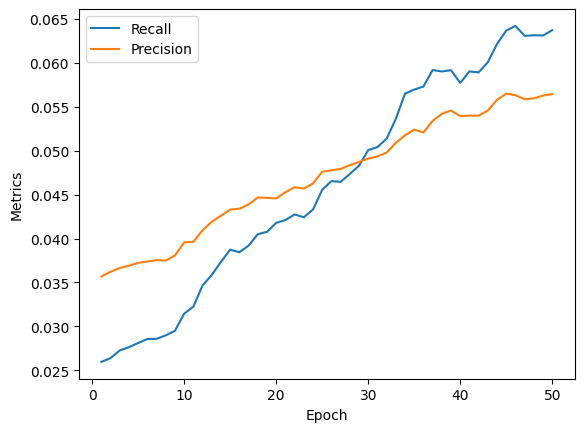

In [142]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

## Training NGCF

In [144]:
ngcf = RecommenderSyem(
  hidden_dims=latent_dim,
  num_layers=n_layers,
  num_user=num_users_training,
  num_items=num_items_training,
  model='NGCF'
)

optimizer = torch.optim.Adam(ngcf.parameters(), lr=LR)

In [146]:
ngcf_loss, ngcf_recall, ngcf_precision = trainer(ngcf, optimizer, train_data)

 48%|████▊     | 24/50 [18:31<21:27, 49.53s/it]

In [147]:
epoch_list = [(i+1) for i in range(EPOCHS)]

In [150]:
ngcf_loss

NameError: name 'ngcf_loss' is not defined